In [1]:
# Pandora public link
# https://pandora.infn.it/public/728eb4

# Install libraries
!pip install pyreadr
!pip install opencv-python
!pip install shap
!pip install tqdm
!pip install jupyslides
!pip install pypandoc
!pip install jupyslides
!wget https://pandora.infn.it/public/f9cc77/dl/DB_test.RData
!wget https://pandora.infn.it/public/dfa7fa/dl/DB_train.RData
!wget https://pandora.infn.it/public/c7d054/dl/lab_test.npy
!wget https://pandora.infn.it/public/9940cc/dl/lab_train.npy
!wget https://pandora.infn.it/public/7c91a8/dl/model_comp.h5

# import libraries
import jupyslides
from jupyslides import jupyslides
import cv2 #manipulating images
import pyreadr as pr #Rdata to python
import pandas as pd
import numpy as np
import random
from random import sample
import math
from IPython.display import display, Image
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
import os
import pickle
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from tqdm import trange
from time import time, sleep
import shap
import keras.backend as K
tf.compat.v1.disable_eager_execution()


[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
--2022-11-07 07:51:10--  https://pandora.infn.it/public/f9cc77/dl/DB_test.RData
Resolving pandora.infn.it (pandora.infn.it)... 131.154.52.50
Connecting t

In [2]:
# IF COLAB: UNCOMMENT NEXT LINES
#!apt-get -y install subversion
#!svn checkout https://github.com/landerlini/mlinfn-advanced-hackathon/trunk/ex/xai/Presentation
#END IF COLAB
slides_path = 'Presentation'
js = jupyslides(slides_path)
js.slideshow()

interactive(children=(FloatSlider(value=1.0, description='zoom', max=2.0, min=0.6, step=0.2), IntSlider(value=…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [3]:
# Training set
DB_balanced = pr.read_r('DB_train.RData')
DB_balanced = DB_balanced['DB_train']

# Test set
DB_test = pr.read_r('DB_test.RData')
DB_test = DB_test['DB_test']

# Training label
lab_train = np.load('lab_train.npy')

# Test label
lab_test = np.load('lab_test.npy')

In [4]:
# Training set
print(DB_balanced.iloc[:10,:5])
print(DB_balanced.shape)

# Test set
print(DB_test.iloc[:10, :5])
print(DB_test.shape)

# Training label
print(lab_train[:10])
print(f"Training Label lenght = {len(lab_train)}.\n")

# Test label
print(lab_test[:10])
print(f"Test Label lenght = {len(lab_test)}.\n")

              chr1_136052  chr1_136915  chr1_564461  chr1_564467  chr1_567459
rownames                                                                     
SRR1313426       0.465523     0.208592     0.337590     0.229242     0.005040
SRR1433088.2     0.465523     0.208592     0.337590     0.229242     0.007031
SRR1343115.1     0.465523     0.200000     0.337590     0.229242     0.007031
SRR660895.1      0.324680     0.193550     0.337590     0.229242     0.007031
322              0.250647     0.125343     0.337590     0.229242     0.007031
SRR1432123       0.733330     0.250000     0.337590     0.142860     0.007031
88               0.463340     0.208592     0.328383     0.225002     0.005138
SRR1396659       0.465523     0.208592     0.337590     0.229242     0.007031
SRR1436444       0.465523     0.208592     0.337590     0.229242     0.010870
SRR1404969       0.611110     0.133330     0.337590     0.229242     0.007031
(1472, 86683)
            chr1_136052  chr1_136915  chr1_564461 

In [5]:
js.slideshow()

interactive(children=(FloatSlider(value=1.0, description='zoom', max=2.0, min=0.6, step=0.2), IntSlider(value=…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [6]:
# Conversion from data to image
chr_num = DB_balanced.columns

# extracting the number of the chromosome to sort
chr=list()
for i in range(len(chr_num)):
  chr.append((chr_num[i].split('chr')[1]).split('_')[0])

# casting to integer
chr=list(map(int, chr))

# sorting number and not charachter
chr_num = chr
ord = np.argsort(chr_num)
names_ord = (DB_balanced.columns)[ord]

# Sorting the columns of the original dataset
Editing_ord = DB_balanced[names_ord]
print(Editing_ord.shape)

# Removing the idexes
Editing_ord.reset_index(inplace=True)
Editing_ord.drop(columns=Editing_ord.columns[0], 
        axis=1, 
        inplace=True)

(1472, 86683)


In [7]:
# finding the perfect square root in order to create the images
root = math.sqrt(Editing_ord.shape[1])
print(f"Square root of the feature number = {root}. \n")
perf_square = math.ceil(root)
n_zero = perf_square**2 - Editing_ord.shape[1]
print(f"{perf_square**2} - {Editing_ord.shape[1]} = {n_zero}. \n")

# adding n_zero columns in order to reach the perfect square
zeros = pd.DataFrame(np.zeros((Editing_ord.shape[0],n_zero)))
print(zeros.shape)
Editing_ord = pd.concat([Editing_ord, zeros],axis=1)
print(Editing_ord.shape)

Square root of the feature number = 294.4197683580367. 

87025 - 86683 = 342. 

(1472, 342)
(1472, 87025)


In [8]:
# Convert vector sample to image
images_train = list()
for i in trange(Editing_ord.shape[0]):
  sleep(0.1)
  images_train.append(np.array(Editing_ord.iloc[i,:]).reshape(perf_square,perf_square, 1))

print(len(images_train))

100%|██████████| 1472/1472 [04:29<00:00,  5.46it/s]

1472


In [9]:
#TEST

# We have to remove the indexes
Editing_ord=DB_test[names_ord]
Editing_ord.reset_index(inplace=True)
Editing_ord.drop(columns=Editing_ord.columns[0], 
        axis=1, 
        inplace=True)

# adding n_zero columns in order to reach the perfect square
zeros = pd.DataFrame(np.zeros((Editing_ord.shape[0],n_zero)))
print(zeros.shape)
Editing_ord = pd.concat([Editing_ord, zeros],axis=1)
print(Editing_ord.shape)

(307, 342)
(307, 87025)


In [10]:
# Convert vector sample to image
images_test = list()
for i in trange(Editing_ord.shape[0]):
  sleep(0.1)
  images_test.append(np.array(Editing_ord.iloc[i,:]).reshape(perf_square,perf_square, 1))

print(len(images_test))

100%|██████████| 307/307 [00:55<00:00,  5.50it/s]

307


In [11]:
# Converting image lists into 4D keras tensors
train = np.array(images_train)
print(train.shape)
test = np.array(images_test)
print(test.shape)

# One hot encode
train_lab = tf.keras.utils.to_categorical(lab_train)
train_lab = np.array(train_lab)
test_lab = tf.keras.utils.to_categorical(lab_test)
test_lab = np.array(test_lab)

(1472, 295, 295, 1)
(307, 295, 295, 1)


In [12]:
# js.slideshow()

In [13]:
# Model Building
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(9,9),
    activation='relu',
    kernel_regularizer=regularizers.L2(1e-3),
    activity_regularizer=regularizers.L2(1e-3),
    kernel_initializer='he_normal',
    bias_regularizer=regularizers.L2(1e-3),
    input_shape=(perf_square,perf_square,1)
))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(4,4),
))

model.add(tf.keras.layers.SpatialDropout2D(0.3))

model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(7,7),
    activation='relu',
    kernel_regularizer=regularizers.L2(1e-3),
    activity_regularizer=regularizers.L2(1e-3),
    kernel_initializer='he_normal',
    bias_regularizer=regularizers.L2(1e-3),
    name='conv_2'
))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(4,4),
))

model.add(tf.keras.layers.SpatialDropout2D(0.3))

model.add(tf.keras.layers.Flatten())


model.add(tf.keras.layers.Dense(units=256,
    kernel_regularizer=regularizers.L2(1e-3),
    activity_regularizer=regularizers.L2(1e-3),
    kernel_initializer='he_normal',
    bias_regularizer=regularizers.L2(1e-3),
    activation='sigmoid'
    ))

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=2,
    kernel_regularizer=regularizers.L2(1e-3),
    activity_regularizer=regularizers.L2(1e-3),
    kernel_initializer='he_normal',
    bias_regularizer=regularizers.L2(1e-3),
    activation='softmax'
    ))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
              )

In [14]:
history=model.fit(train,
                  train_lab,
                  epochs=100,
                  batch_size=40,
                  validation_split=0.2,
                  verbose = 1)

hist=history.history

Train on 1177 samples, validate on 295 samples


2022-11-07 07:57:04.340972: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-07 07:57:05.548694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30985 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0


Epoch 1/100


2022-11-07 07:57:06.918282: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


1177/1177 [==============================] - ETA: 0s - loss: 110.2832 - accuracy: 0.4860

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


1177/1177 [==============================] - 5s 4ms/sample - loss: 110.2832 - accuracy: 0.4860 - val_loss: 27.8925 - val_accuracy: 0.4746
Epoch 2/100
1177/1177 [==============================] - 2s 2ms/sample - loss: 14.6624 - accuracy: 0.4962 - val_loss: 7.3336 - val_accuracy: 0.4746
Epoch 3/100
1177/1177 [==============================] - 2s 2ms/sample - loss: 5.5061 - accuracy: 0.4970 - val_loss: 4.0428 - val_accuracy: 0.5254
Epoch 4/100
1177/1177 [==============================] - 2s 2ms/sample - loss: 3.4674 - accuracy: 0.5089 - val_loss: 2.8592 - val_accuracy: 0.5695
Epoch 5/100
1177/1177 [==============================] - 2s 2ms/sample - loss: 2.5906 - accuracy: 0.5319 - val_loss: 2.2683 - val_accuracy: 0.4746
Epoch 6/100
1177/1177 [==============================] - 2s 2ms/sample - loss: 2.1116 - accuracy: 0.5624 - val_loss: 1.9104 - val_accuracy: 0.5458
Epoch 7/100
1177/1177 [==============================] - 2s 2ms/sample - loss: 1.8138 - accuracy: 0.6066 - val_loss: 1.6766 - 

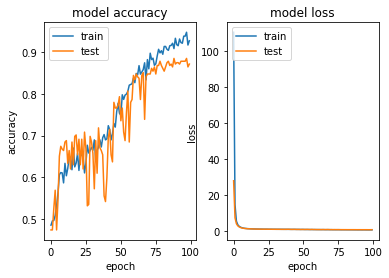

In [15]:
#np.load('my_history.npy', allow_pickle=True)
# summarize history for accuracy
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')
# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# Model load
model = tf.keras.models.load_model('model_comp.h5')
model.evaluate(test, test_lab)

y_pred = model.predict(test)
y_pred = np.argmax(y_pred, axis=1)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


In [17]:
lab = np.array([int(numeric_string) for numeric_string in lab_test])

cm1 = confusion_matrix(lab, y_pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1 = (cm1[0,0] + cm1[1,1])/total1
print('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0] + cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0] + cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[189  43]
 [ 14  61]]
Accuracy :  0.8143322475570033
Sensitivity :  0.8146551724137931
Specificity :  0.8133333333333334


In [18]:
# grad_cam function
def grad_cam(model, X, c, layer_name, size, img=None):
  # c -> identifica la classe di nostro interesse
  # k -> identifica il numero delle fetures map
  # A -> identifica le feature maps

  y_c = model.output[0, c] # prende il valore di prob della classe predetta
  conv = model.get_layer(layer_name) # ricava l'ultimo layer convoluzionale i cui output sono le feature maps
  grads = K.gradients(y_c, conv.output)[0] # derivata di y_c rispetto le feature maps
  # è una matrice i cui eleenti sono i gradienti di y_c e A_ij
  # K.function permette di runnare il grafo computazionele che abbiamo creato
  # in questo caso abbiamo un input e 2 otuput: (i) le features maps (ii) il gradiente all'ultimo livello convoluzionale
  gradient_function = K.function([model.input], [conv.output, grads]) # l'output dell'ultimo strato conv sono features maps
  feature_maps, grads_val = gradient_function([X])
  feature_maps, grads_val = feature_maps[0, ...], grads_val[0, ...]

  # a_{k} ^c
  # Andiamo a calcolare il global average pooling (GAP) del gradiente
  weights = np.mean(grads_val, axis=(0, 1)) #media su tutta la feature maps, un peso per ogni feature map, è un vettore
  
  # sum_{k} ( a_{k} ^c * A^{k})
  products = np.empty((feature_maps.shape), dtype='float32')
  for i in range(feature_maps.shape[2]): # feature_maps.shape[2] conta la terza dimensione, cioè quante feat maps ci sono
    products[:,:,i] = weights[i] * feature_maps[:,:,i] # sono un gruppo di matrici
  linear_combination = np.sum(products, axis=2) # sommo matrice per matrice, lungo la terza dimensione
 
  # ReLU ( sum_{k} ( a_{k} ^c * A^{k}) )
  grad_cam = np.maximum(linear_combination, 0) # prende il valore dell'istanza della feat maps finale ottenuta solo se positivo

  # Process grad_CAM
  grad_cam = cv2.resize(grad_cam, (size, size), cv2.INTER_LINEAR) # porto la dimensione della maschera a quelle dell'input
  grad_cam = grad_cam / grad_cam.max() # normalizzo i valori della maschera
  grad_cam = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET) # applico i colori alla maschera
  if img is not None:
    grad_cam = (np.float32(grad_cam) + img) / 2 # sommo la maschera e l'input, dvido per due per non contare due volte i pixel
  else:
    grad_cam = np.float32(grad_cam)
  return np.uint8(grad_cam) # uint8 sono interi a 8 bit da 0 a 255

In [19]:
#function to perform mean
def grad_cam_mean(test_0, c, model, size):
 h_array=[]
 for i in trange(test_0.shape[0]):
    sleep(0.1)
    x = test_0[i,:,:,:]
    x = x[None, :]
    # x = np.expand_dims(x, axis=0)
    h = grad_cam(model, x, c, 'conv_2', size)
    h_array.append(h)
 #h_fin= h_array[0,:,:,:].mean
    
 return (h_array)

In [20]:
#grad_cam application
test = np.array(images_test)
w = grad_cam_mean(test[np.where(lab_test != '0')[0],:,:,:], 1, model, perf_square)
m = grad_cam_mean(test[np.where(lab_test == '0')[0],:,:,:], 0, model, perf_square)

#process output
w = np.array(w)
w = w.mean(axis=0)

m = np.array(m)
m = m.mean(axis=0)

100%|██████████| 232/232 [12:10<00:00,  3.15s/it]


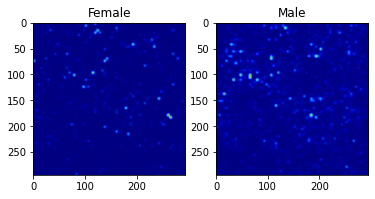

In [21]:
# IF COLAB: UNCOMMENT NEXT LINES
#!apt-get -y install subversion
#!svn checkout https://github.com/landerlini/mlinfn-advanced-hackathon/trunk/ex/xai/GradCAM
#END IF COLAB

np.load("GradCAM/m.npy")
np.load("GradCAM/w.npy")

#display
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cv2.cvtColor(np.uint8(w), cv2.COLOR_BGR2RGB))
ax1.set_title('Female')
ax2.imshow(cv2.cvtColor(np.uint8(m), cv2.COLOR_BGR2RGB))
ax2.set_title('Male')
plt.show()

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


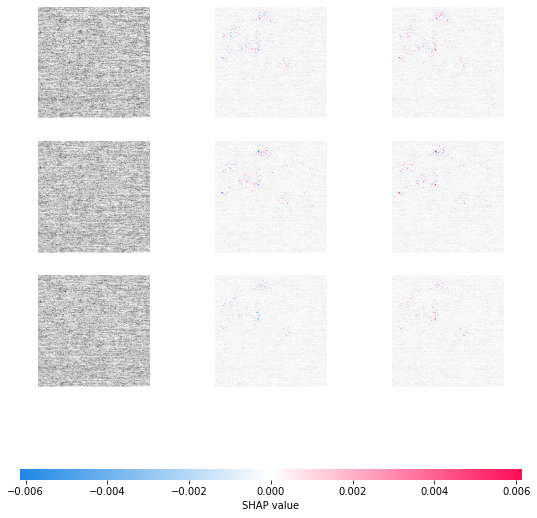

In [22]:
#SHAP
ex = shap.DeepExplainer(model, train[0:100])

#calculate Shapley values
shap_values = ex.shap_values(test[0:100])

#display first 3 results
shap.image_plot(shap_values, -test[0:3])

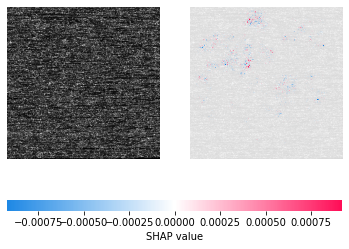

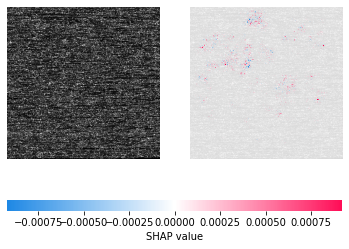

In [23]:
#perform mean
w2 = np.array(shap_values)[1].mean(axis=0)
m2 = np.array(shap_values)[0].mean(axis=0)

#plot result woman
shap.image_plot(w2, test[0])

#plot result man
shap.image_plot(m2, test[0])

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


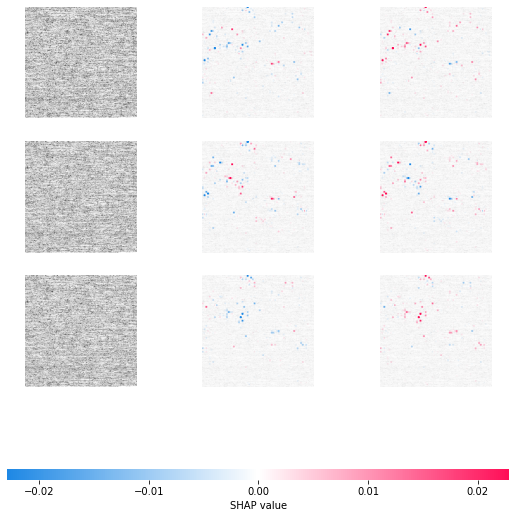

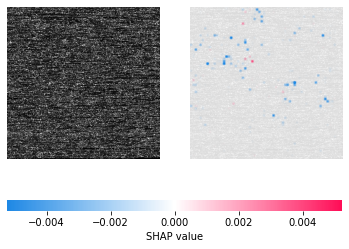

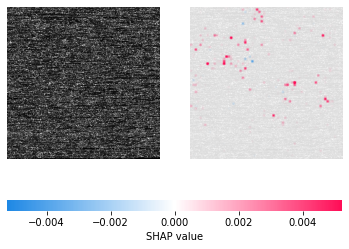

In [24]:
#intermediate layer model
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[3].output)

# explain how the input to the last convolutional layer of the model explains the two classes
ex2 = shap.GradientExplainer(
    (model.layers[4].input, model.layers[-1].output),
     intermediate_layer_model.predict(train[0:100]),
    local_smoothing=0 # std dev of smoothing noise
)

shap_values2 = ex2.shap_values(intermediate_layer_model.predict(test[0:100]))
shap.image_plot(shap_values2[0:3], -test[0:3])

#mean of results
w3 = np.array(shap_values2)[1].mean(axis=0)
m3 = np.array(shap_values2)[0].mean(axis=0)

shap.image_plot(w3, test[0])
shap.image_plot(m3, test[0])